In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image 
import PIL
import torch

sns.set(style='white', context='notebook', palette='muted')
import matplotlib.pyplot as plt

train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

display(train.head())
#full = pd.concat([train, test], ignore_index=True);

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
test.info()

1. Preprocessing

1.1 Dataset Preparing

In [3]:
#create related dir
import os

print(os.getcwd())
if not os.path.exists('dataset/test'):
    os.makedirs('dataset/test')
if not os.path.exists('dataset/train'):
    os.mkdir('dataset/train')
if not os.path.exists('check_points'):
    os.mkdir('check_points')

/kaggle/working


In [4]:
#array to image
def a2i(indata):
    mg = Image.new('L', (28, 28))
    mg.putdata(indata)
    return mg

#generate train dataset
train_numpy = train.to_numpy()
r,_ = train_numpy.shape
for i in range(0, r):
     img = a2i(train_numpy[i, 1:])
     img.save('/kaggle/working/dataset/train/%d_%d.png' % (train_numpy[i, 0], i)) #label_num

In [5]:
#generate test dataset
test_numpy = test.to_numpy()

r,_ = test_numpy.shape
for i in range(0, r):
     img = a2i(test_numpy[i, :])
     img.save('/kaggle/working/dataset/test/%d.png' % (i+1))

1.2 Dataset and DataLoader

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import glob
import cv2

In [7]:
class DigRecDataset(Dataset):
    def __init__(self, mode, directory, transform=None):
        super(DigRecDataset, self).__init__()
        self.transform = transform
        self.mode = mode
        self.directory = directory
        self.file_names = []
        for path in glob.glob(os.path.join(self.directory, mode, '*.png')):
            self.file_names.append(path)
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.file_names[idx], cv2.IMREAD_GRAYSCALE)
        img = PIL.Image.fromarray(img)

        label = -1
        Id = -1
        if self.mode == 'train':
            if self.transform is not None:
                img = self.transform(img)
            label, Id = self.file_names[idx].split('/')[-1].split('.')[0].split('_')
        else:
            img = transforms.ToTensor()(img)
            Id = self.file_names[idx].split('/')[-1].split('.')[0]
            
        return img, torch.tensor(int(label), dtype=torch.int8) , int(Id)

1.3 Data Augmentation

In [9]:
TRANSFORMS = transforms.Compose([
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=(0, 15), translate=(0, 0.15), scale=(0.85, 1.15)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
    transforms.ToTensor()
])

2. Model

2.1 Build Model

In [35]:
import torch.nn as nn

class Conv(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, kernel_size=1, Norm=True, activation='Relu', padding=0):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,padding=padding)
        if activation == 'Relu':
            self.activate = nn.ReLU()
        self.bn = None
        if Norm is not None:
            self.bn = nn.BatchNorm2d(out_planes)
            
    def forward(self, x):
        if self.bn is not None:
            return self.activate(self.bn(self.conv(x)))
        else:
            return self.activate(self.conv(x))

class Model(nn.Module):
    def __init__(self, planes, mid_planes):
        super(Model, self).__init__()
        self.in_planes = planes
        self.conv1 = Conv(planes, mid_planes, kernel_size=3)#[26,26,32]
        self.ds_conv1 = Conv(mid_planes, 2*mid_planes, kernel_size=3, stride=2, padding=1)#[13,13,64]
        self.conv2 = Conv(2*mid_planes, 4*mid_planes, kernel_size=3)#[11,11,128]
        self.ds_conv2 = Conv(4*mid_planes, 8*mid_planes, kernel_size=3, stride=2, padding=1)#[5,5,256]
        self.linear1 = nn.Linear(6*6*8*mid_planes, 4*mid_planes)
        self.linear2 = nn.Linear(4*mid_planes, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.ds_conv1(x)
        x = self.dropout(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.ds_conv2(x)
        x = self.dropout(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        
        return x
        

2.2 Build dataset and dataloader

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

directory = 'dataset'
BATCH_SIZE = 192
random_seed= 42
validation_split = 0.1
shuffle_dataset = True
dataset = DigRecDataset(mode='train', directory=directory, transform=TRANSFORMS)

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(
        dataset,
        sampler=sample_train,
        batch_size=BATCH_SIZE,
        #shuffle = True,
        drop_last=False
    )
val_loader = DataLoader(
        dataset,
        sampler=valid_sampler,
        batch_size=BATCH_SIZE,
        drop_last=False
    )

2.3 Train model

In [36]:
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(1,16)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

#from torch.utils.tensorboard import SummaryWriter

In [37]:
model

Model(
  (conv1): Conv(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (activate): ReLU()
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ds_conv1): Conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activate): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (activate): ReLU()
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ds_conv2): Conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activate): ReLU()
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=4608, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=Fal

In [14]:
device

device(type='cuda')

In [38]:
loss_arry = []
val_loss_avg = []
epochs = 40
global_step = 0
print_freq = 20
for epoch in range(epochs):
    print("----------{} th epoch training start----------".format(epoch))
    model.train()
    for images, labels, _ in iter(train_loader):
        images = images.to(device)
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        loss_arry.append(loss)
        if (global_step+1) % print_freq == 0:
            print('{step} th training steps, the train loss is: {loss}'.format(step=global_step, loss=loss))
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        global_step += 1
     
    if epoch > epochs//2:
        torch.save(model.state_dict(), 
                    'check_points/checkpoint_{}_epoch.pth'.format(epoch))
        
    print("{} th epoch validation start...".format(epoch))
    model.eval()
    sum_eval_loss = 0
    cnt = 0
    for images, labels, _, in iter(val_loader):
        images = images.to(device)
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        sum_eval_loss += loss
        cnt += 1
        if cnt % print_freq == 0:
            print('{step} th validating steps, the validating loss is: {loss}'.format(step=cnt, loss=loss))
            
    val_loss_avg.append(sum_eval_loss / cnt)

----------0 th epoch training start----------
19 th training steps, the train loss is: 1.18142569065094
39 th training steps, the train loss is: 0.6153749227523804
59 th training steps, the train loss is: 0.5492069721221924
79 th training steps, the train loss is: 0.4004601538181305
99 th training steps, the train loss is: 0.4050404727458954
119 th training steps, the train loss is: 0.28035101294517517
139 th training steps, the train loss is: 0.23691284656524658
159 th training steps, the train loss is: 0.22199024260044098
179 th training steps, the train loss is: 0.20225279033184052
199 th training steps, the train loss is: 0.20623807609081268
0 th epoch validation start...
20 th validating steps, the validating loss is: 0.28411948680877686
----------1 th epoch training start----------
219 th training steps, the train loss is: 0.26450321078300476
239 th training steps, the train loss is: 0.20909108221530914
259 th training steps, the train loss is: 0.2158118635416031
279 th training 

In [39]:
d = {'loss':[l.cpu().detach().item() for l in loss_arry], 'step':range(global_step)}
train_loss = pd.DataFrame(d)
train_loss.head()

,loss,step
0,2.353513,0
1,2.677743,1
2,2.355020,2
3,2.207799,3
4,1.986154,4


In [ ]:
train_loss.info()

<Axes: xlabel='step', ylabel='loss'>

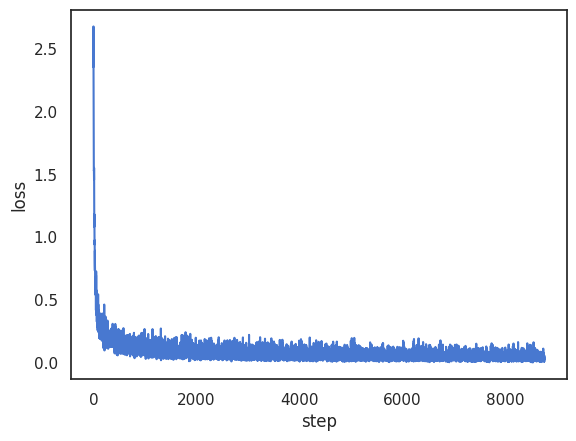

In [40]:
sns.lineplot(data=train_loss, x="step", y="loss")

<Axes: xlabel='step', ylabel='loss'>

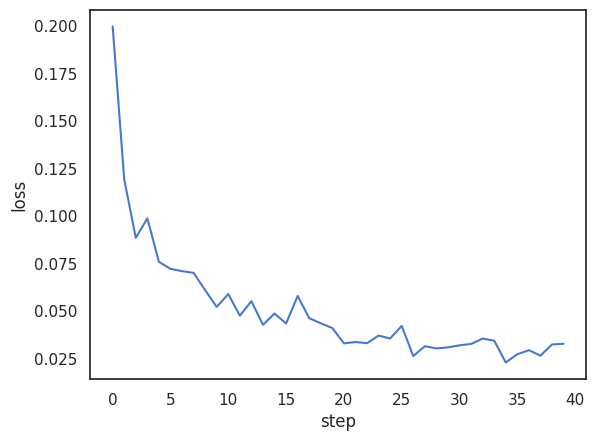

In [41]:
eval_d = {'loss':[l.cpu().detach().item() for l in val_loss_avg], 'step':range(epochs)}
val_loss = pd.DataFrame(eval_d)
sns.lineplot(data=val_loss, x="step", y="loss")

3. Prediction

In [42]:
model.load_state_dict(torch.load("check_points/checkpoint_34_epoch.pth"))

<All keys matched successfully>

In [43]:
#single instance infer
def single_ins_infer(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = PIL.Image.fromarray(img)
    img = transforms.ToTensor()(img)
    img = img.to(device)
    img = img[None, ...]
    with torch.no_grad():
        outputs = model(img)
    pred = []
    score = []
    # pred = torch.argmax(outputs, dim=-1)
    score, pred = torch.max(outputs, dim=-1)
    Id = path.split('/')[-1].split('.')[0]
    return pred, score, int(Id)

In [ ]:
# test_dataset = DigRecDataset(mode='test', directory=directory)
# test_loader = DataLoader(
#         test_dataset,
#         batch_size=1,
#         shuffle=True,
#         drop_last=False
#     )

In [ ]:
# Ids = []
# predictions = []
# scores = []
# for b_idx,(images, _, id) in enumerate(test_loader):
#     Ids.append(id)
#     images = images.to(device)
    
#     with torch.no_grad():
#         outputs = model(images)
        
#     #outputs = F.softmax(outputs, dim=-1)
#     predictions.append(torch.argmax(outputs, dim=-1))
#     scores.append(torch.max(outputs, dim=-1))
#     break


In [44]:
Ids = []
predictions = []
scores = []
print_freq = 1000
count = 0
model.eval()
for path in glob.glob(os.path.join('dataset', 'test', '*.png')):
    pred, score, Id = single_ins_infer(path)
    Ids.append(Id)
    predictions.append(pred.cpu().detach().item())
    scores.append(score.cpu().detach().item())
    if count % 1000 == 0:
        print('infered %d test images...' % count)
    count += 1

infered 0 test images...
infered 1000 test images...
infered 2000 test images...
infered 3000 test images...
infered 4000 test images...
infered 5000 test images...
infered 6000 test images...
infered 7000 test images...
infered 8000 test images...
infered 9000 test images...
infered 10000 test images...
infered 11000 test images...
infered 12000 test images...
infered 13000 test images...
infered 14000 test images...
infered 15000 test images...
infered 16000 test images...
infered 17000 test images...
infered 18000 test images...
infered 19000 test images...
infered 20000 test images...
infered 21000 test images...
infered 22000 test images...
infered 23000 test images...
infered 24000 test images...
infered 25000 test images...
infered 26000 test images...
infered 27000 test images...


In [45]:
d = {'ImageId': Ids, 'Label': predictions}
Result = pd.DataFrame(d)

In [46]:
Result.head(20)

,ImageId,Label
0,12907,0
1,27043,3
2,24778,8
3,856,8
4,21947,6
5,8897,3
6,13050,3
7,27470,6
8,25189,0
9,22833,4


In [47]:
Result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ImageId  28000 non-null  int64
 1   Label    28000 non-null  int64
dtypes: int64(2)
memory usage: 437.6 KB


In [48]:
Result.to_csv('Tao_digit_reg.csv', index=False)

In [ ]:
#zip dataset
# from flask import Flask, send_file
# import zipfile

# def zipDir(dirpath, outFullName):
#     zip = zipfile.ZipFile(outFullName, "w", zipfile.ZIP_DEFLATED)
#     for path, dirnames, filenames in os.walk(dirpath):
#         fpath = path.replace(dirpath, '')
#         for filename in filenames:
#             zip.write(os.path.join(path, filename), os.path.join(fpath, filename))

# folder_path = "dataset"  
# zip_path = "data.zip" 
# zipDir(folder_path, zip_path)  
